In [1]:
#from gcca import GCCA
import logging
# set log level
logging.root.setLevel(level=logging.INFO)
import numpy as np
from scipy import linalg,stats
from scipy.sparse.linalg import svds
# from sklearn.decomposition import TruncatedSVD
import glob
from tqdm import tqdm
from sklearn.preprocessing import normalize

from pathlib import Path
import re
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## See https://github.com/rupy/GCCA

from sklearn.cross_decomposition import CCA

## Load Data

In [2]:
basedir = Path('..')
datadir = basedir / 'data' / 'raw'
correlation_dir = basedir / 'data' / 'interim' / 'latents'

In [3]:
## Grab filenames
def get_files(level='(e|n)',
              subject='([0-9]{3})',
              task='(.+?)'):
    files = []
    query = f'^{level}_sub-'
    query += f'{subject}_ses-1_'
    query += f'task-{task}\.csv'
    for f in os.listdir(datadir):
        match = re.search(query, f)
        if match:
            files.append((f, match.groups()))
    
    return(files)

In [4]:
tasks = ['restingstate', 'openmonitoring', 'compassion']
levels = ['e', 'n']

#for task,level in np.array(np.meshgrid(tasks,levels)).T.reshape(-1,2):
#    paths = get_files(level=level, task=task)

paths = get_files(level=levels[0], task=tasks[2])[:2]

In [294]:
data = []
subjs = []
for path,subj in paths[:2]:
    data.append(pd.read_csv(datadir / path, header = None).to_numpy())
    subjs.append(subj)

## GCCA

In [295]:
def _preprocess(x):
    # Mean along rows using sample mean and sample std
    x2 = stats.zscore(x,axis=1,ddof=1) 
    # Mean along columns
    mu = np.mean(x2,axis=0)
    x2 -= mu
    return(x2)

def gcca(data, rank_tolerance=None, n_components=None):
    n = data[0].shape[0]
    
    metadata = []

    data = [_preprocess(x) for x in data]
    
    Uall = []
    Sall = []
    Vall = []
    ranks = []
    
    for x in tqdm(data):
        temp = {}
        # Preprocess
        x[np.isnan(x)] = 0
        
        temp['X'] = x

        # compute the SVD of the data
        u,s,vt = linalg.svd(x, full_matrices=False)
        temp['S'] = s; temp['V'] = vt.T

        Sall.append(s)
        Vall.append(vt.T)
        # Dimensions to reduce to
        if rank_tolerance:
            rank = sum(s > rank_tolerance)
        else:
            rank = n_components
            
        temp['rank']=rank
        ranks.append(rank)
        u = u[:,:rank]
        Uall.append(u)
        temp['U'] = u
        
        metadata.append(temp); temp=None
        
    d = min(ranks)

    # Create a concatenated view of Us
    Uall_c = np.concatenate(Uall,axis=1)

    _,_,VV=svds(Uall_c,d)
    VV = np.flip(VV.T,axis=1)
    VV = VV[:,:min([d,VV.shape[1]])]

    # SVDS the concatenated Us
    idx_end = 0
    projX = []
    for i in range(len(data)):
        idx_start = idx_end
        idx_end = idx_start + ranks[i]
        VVi = normalize(VV[idx_start:idx_end,:],'l2',axis=0)
        metadata[i]['VVi']=VVi
        # Compute the canonical projections
        A = np.sqrt(n-1) * Vall[i][:,:ranks[i]]
        metadata[i]['inv'] = linalg.solve(np.diag(Sall[i][:ranks[i]]), VVi)
        A = A @ metadata[i]['inv']
        projX.append(data[i] @ A)
        
        metadata[i]['A'] = A
        metadata[i]['projX'] = projX[-1]
        
    return(projX, metadata, Uall_c, VV)

In [296]:
num_views = 2 # Number of subjects (views) to consider
rank_tolerance = 300

In [297]:
projs, metadata, Uall_c, VV = gcca(data=data, rank_tolerance=rank_tolerance)

100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


In [206]:
metadata[0]['inv']

array([[ 1.2915e-03, -3.0387e-04,  1.2745e-04,  4.4230e-04, -3.2357e-05],
       [ 5.6498e-04, -2.1750e-04, -8.0049e-04, -1.4954e-03,  9.9977e-04],
       [ 4.9269e-04,  1.9010e-03,  7.4595e-04, -3.3009e-04,  2.3869e-04],
       [-3.0252e-04,  2.9424e-04, -5.3728e-04,  1.3767e-03,  1.8639e-03],
       [-2.9164e-04, -1.0439e-03,  2.2998e-03, -4.4699e-04,  1.1105e-03]])

In [174]:
#metadata[0]['U']
max((Uall_c - mUall).flatten())

0.05887009380823763

In [168]:
mpath = basedir / 'data' / 'matlab_Uall.csv'
mUall = pd.read_csv(mpath, header=None).to_numpy()

In [291]:
mu = [1,2,3,1,2,3]
var = [1,1,1,2,2,2]
n_features = 10
n_subjects = 2
test_data = np.zeros(shape=(n_subjects,len(mu),n_features))
for s in range(n_subjects):
    for m in range(len(mu)):
        for i in range(n_features):
            test_data[s,m,i] = np.random.normal(mu[m]-s, var[m]+s)

In [292]:
projs, metadata, Uall_c, VV = gcca(data=test_data, rank_tolerance=1.5)

100%|██████████| 2/2 [00:00<00:00, 695.86it/s]

U shape: (6, 5)
V shape: (10, 6)
(10, 5)
(5, 5)
(10, 5)
(5, 5)


/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


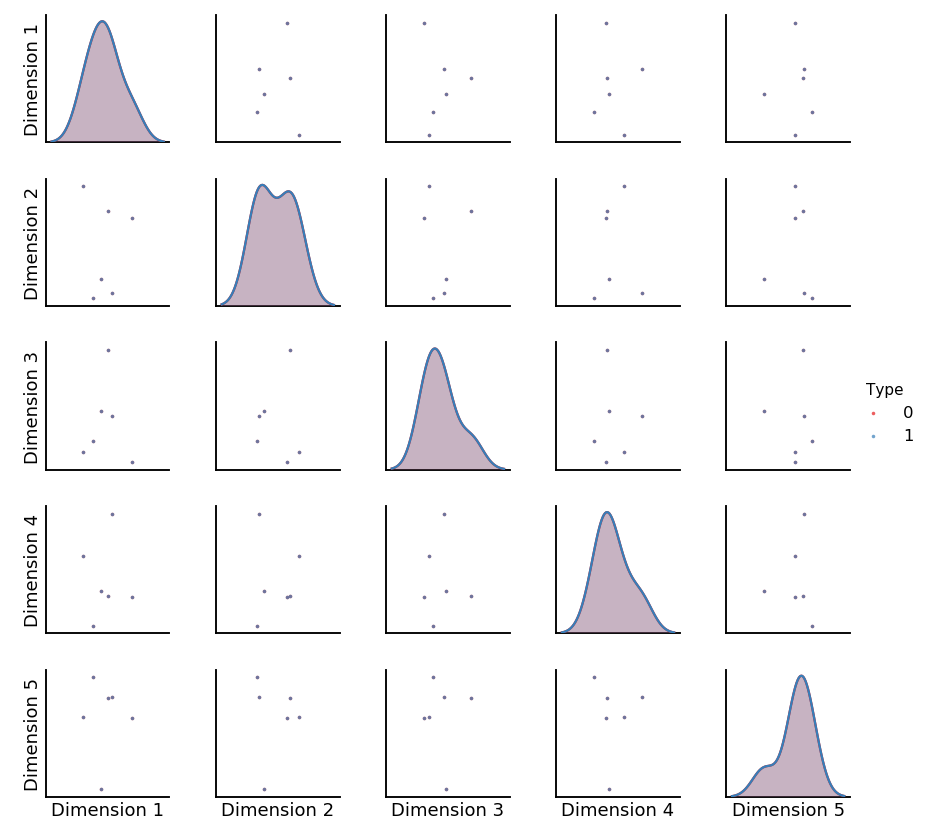

In [293]:
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in [[i] for i in range(n_subjects)])))

## GCCA Rupy Implementation

In [8]:
import numpy as np
from scipy.linalg import eig
import logging
import os
import matplotlib.pyplot as plt
import math
from matplotlib import colors
import h5py

class GCCA:

    def __init__(self, n_components=2, reg_param=0.1):

        # log setting
        program = os.path.basename(__name__)
        self.logger = logging.getLogger(program)
        logging.basicConfig(format='%(asctime)s : %(name)s : %(levelname)s : %(message)s')

        # GCCA params
        self.n_components = n_components
        self.reg_param = reg_param

        # result of fitting
        self.data_num = 0
        self.cov_mat = [[]]
        self.h_list = []
        self.eigvals = np.array([])

        # result of transformation
        self.z_list = []

    def eigvec_normalization(self, eig_vecs, x_var):
        self.logger.info("normalization")
        z_var = np.dot(eig_vecs.T, np.dot(x_var, eig_vecs))
        invvar = np.diag(np.reciprocal(np.sqrt(np.diag(z_var))))
        eig_vecs = np.dot(eig_vecs, invvar)
        # print np.dot(eig_vecs.T, np.dot(x_var, eig_vecs)).round().astype(int)
        return eig_vecs


    def solve_eigprob(self, left, right):

        self.logger.info("calculating eigen dimension")
        eig_dim = min([np.linalg.matrix_rank(left), np.linalg.matrix_rank(right)])

        self.logger.info("calculating eigenvalues & eigenvector")
        eig_vals, eig_vecs = eig(left, right)

        self.logger.info("sorting eigenvalues & eigenvector")
        sort_indices = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[sort_indices][:eig_dim].real
        eig_vecs = eig_vecs[:,sort_indices][:,:eig_dim].real

        return eig_vals, eig_vecs

    def calc_cov_mat(self, x_list):

        data_num = len(x_list)

        self.logger.info("calc variance & covariance matrix")
        z = np.vstack([x.T for x in x_list])
        cov = np.cov(z)
        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = [[np.array([]) for col in range(data_num)] for row in range(data_num)]
        for i in range(data_num):
            for j in range(data_num):
                i_start, i_end = d_list[i], d_list[i + 1]
                j_start, j_end = d_list[j], d_list[j + 1]
                cov_mat[i][j] = cov[i_start:i_end, j_start:j_end]

        return cov_mat

    def add_regularization_term(self, cov_mat):

        data_num = len(cov_mat)

        # regularization
        self.logger.info("adding regularization term")
        for i in range(data_num):
            cov_mat[i][i] += self.reg_param * np.average(np.diag(cov_mat[i][i])) * np.eye(cov_mat[i][i].shape[0])

        return cov_mat

    def fit(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        d_list = [0] + [sum([len(x.T) for x in x_list][:i + 1]) for i in range(data_num)]
        cov_mat = self.calc_cov_mat(x_norm_list)
        cov_mat = self.add_regularization_term(cov_mat)

        self.logger.info("calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )")
        # left = A, right = B
        left = 0.5 * np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i == j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )
        right = np.vstack(
            [
                np.hstack([np.zeros_like(cov_mat[i][j]) if i != j else cov_mat[i][j] for j in range(data_num)])
                for i in range(data_num)
            ]
        )

        # calc GEV
        self.logger.info("solving")
        eigvals, eigvecs = self.solve_eigprob(left, right)

        h_list = [eigvecs[start:end] for start, end in zip(d_list[0:-1], d_list[1:])]
        h_list_norm = [self.eigvec_normalization(h, cov_mat[i][i]) for i, h in enumerate(h_list)]

        # substitute local variables for member variables
        self.data_num = data_num
        self.cov_mat = cov_mat
        self.h_list = h_list_norm
        self.eigvals = eigvals

    def transform(self, *x_list):

        # data size check
        data_num = len(x_list)
        self.logger.info("data num is %d", data_num)
        for i, x in enumerate(x_list):
            self.logger.info("data shape x_%d: %s", i, x.shape)

        if self.data_num != data_num:
            raise Exception('data num when fitting is different from data num to be transformed')

        self.logger.info("normalizing")
        x_norm_list = [ self.normalize(x) for x in x_list]

        self.logger.info("transform matrices by GCCA")
        z_list = [np.dot(x, h_vec) for x, h_vec in zip(x_norm_list, self.h_list)]

        self.z_list = z_list

        return z_list

    def fit_transform(self, *x_list):
        self.fit(x_list)
        self.transform(x_list)

    @staticmethod
    def normalize(mat):
        m = np.mean(mat, axis=0)
        mat = mat - m
        return mat

    def save_params(self, filepath):

        self.logger.info("saving to %s", filepath)
        with h5py.File(filepath, 'w') as f:
            f.create_dataset("n_components", data=self.n_components)
            f.create_dataset("reg_param", data=self.reg_param)
            f.create_dataset("data_num", data=self.data_num)

            cov_grp = f.create_group("cov_mat")
            for i, row in enumerate(self.cov_mat):
                for j, cov in enumerate(row):
                    cov_grp.create_dataset(str(i) + "_" + str(j), data=cov)

            h_grp = f.create_group("h_list")
            for i, h in enumerate(self.h_list):
                h_grp.create_dataset(str(i), data=h)

            f.create_dataset("eig_vals", data=self.eigvals)

            if len(self.z_list) != 0:
                z_grp = f.create_group("z_list")
                for i, z in enumerate(self.z_list):
                    z_grp.create_dataset(str(i), data=z)
            f.flush()

    def load_params(self, filepath):
        self.logger.info("loading from %s", filepath)
        with h5py.File(filepath, "r") as f:
            self.n_components = f["n_components"].value
            self.reg_param = f["reg_param"].value
            self.data_num = f["data_num"].value

            self.cov_mat = [[np.array([]) for col in range(self.data_num)] for row in range(self.data_num)]
            for i in range(self.data_num):
                for j in range(self.data_num):
                    self.cov_mat[i][j] = f["cov_mat/" + str(i) + "_" + str(j)]
            self.h_list = [None] * self.data_num
            for i in range(self.data_num):
                self.h_list[i] = f["h_list/" + str(i)].value
            self.eig_vals = f["eig_vals"].value

            if "z_list" in f:
                self.z_list = [None] * self.data_num
                for i in range(self.data_num):
                    self.z_list[i] = f["z_list/" + str(i)].value
            f.flush()

    def plot_result(self):

        self.logger.info("plotting result")
        col_num = int(math.ceil(math.sqrt(self.data_num + 1)))
        row_num = int((self.data_num + 1) / float(col_num))
        if row_num != (self.data_num + 1) / float(col_num):
            row_num += 1

        # begin plot
        plt.figure()

        color_list = colors.cnames.keys()
        for i in range(self.data_num):

            plt.subplot(row_num, col_num, i + 1)
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_%d(GCCA)" % (i + 1))

        plt.subplot(row_num, col_num, self.data_num + 1)
        for i in range(self.data_num):
            plt.plot(self.z_list[i][:, 0], self.z_list[i][:, 1], c=color_list[i], marker='.', ls=' ')
            plt.title("Z_ALL(GCCA)")

        plt.show()

    def calc_correlations(self):
        for i, z_i in enumerate(self.z_list):
            for j, z_j in enumerate(self.z_list):
                if i < j:
                   print("(%d, %d): %f" % (i, j, np.corrcoef(z_i[:,0], z_j[:,0])[0, 1]))

In [19]:
gcca = GCCA(n_components=4, reg_param=0)
gcca.fit(data[0], data[1])
projs2 = gcca.transform(data[0], data[1])

2019-07-25 06:06:51,188 : __main__ : INFO : data num is 2
2019-07-25 06:06:51,192 : __main__ : INFO : data shape x_0: (18715, 300)
2019-07-25 06:06:51,195 : __main__ : INFO : data shape x_1: (18715, 300)
2019-07-25 06:06:51,196 : __main__ : INFO : normalizing
2019-07-25 06:06:51,350 : __main__ : INFO : calc variance & covariance matrix
2019-07-25 06:06:51,801 : __main__ : INFO : adding regularization term
2019-07-25 06:06:51,803 : __main__ : INFO : calculating generalized eigenvalue problem ( A*u = (lambda)*B*u )
2019-07-25 06:06:51,822 : __main__ : INFO : solving
2019-07-25 06:06:51,823 : __main__ : INFO : calculating eigen dimension
2019-07-25 06:06:52,047 : __main__ : INFO : calculating eigenvalues & eigenvector
2019-07-25 06:06:54,691 : __main__ : INFO : sorting eigenvalues & eigenvector
2019-07-25 06:06:54,694 : __main__ : INFO : normalization
2019-07-25 06:06:54,722 : __main__ : INFO : normalization
2019-07-25 06:06:54,771 : __main__ : INFO : data num is 2
2019-07-25 06:06:54,772

In [17]:
import graspy
from graspy.plot import pairplot
%matplotlib inline

## CCA

In [13]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=4)
cca.fit(data[0],data[1])


X_c, Y_c = cca.transform(data[0],data[1])

In [14]:
len(Y_c)

18715

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


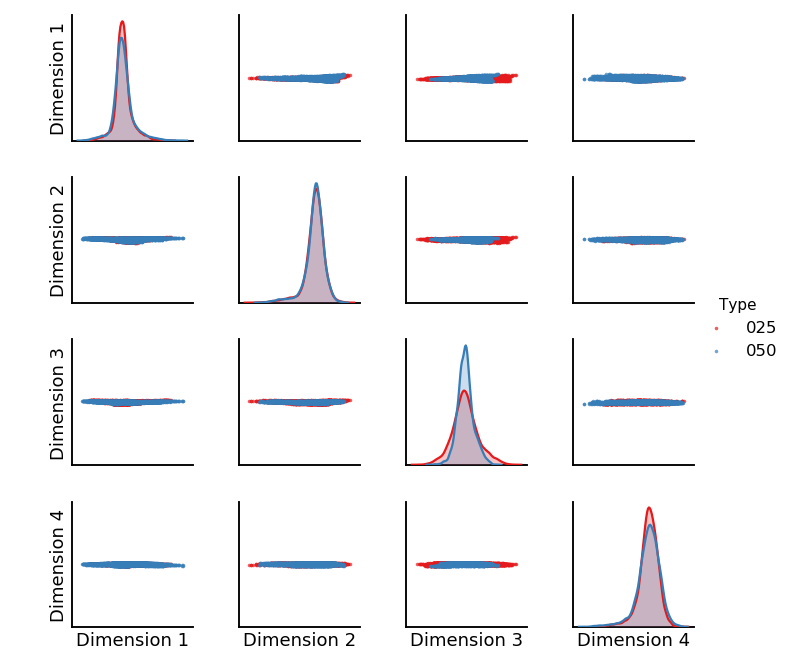

In [17]:
## My Python
pairplot(np.vstack((X_c,Y_c)), labels=np.hstack((i*len(Y_c) for i in subjs)))

## Compare

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


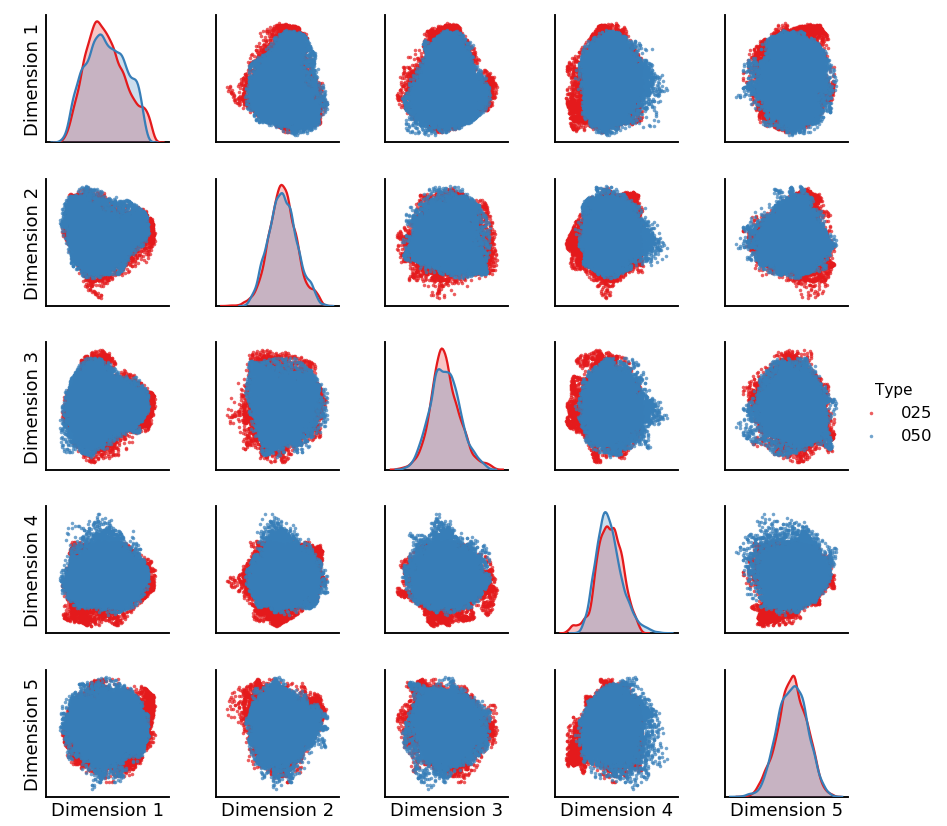

In [232]:
## My Python
pairplot(np.vstack(projs), labels=np.hstack((i*projs[0].shape[0] for i in subjs)))

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


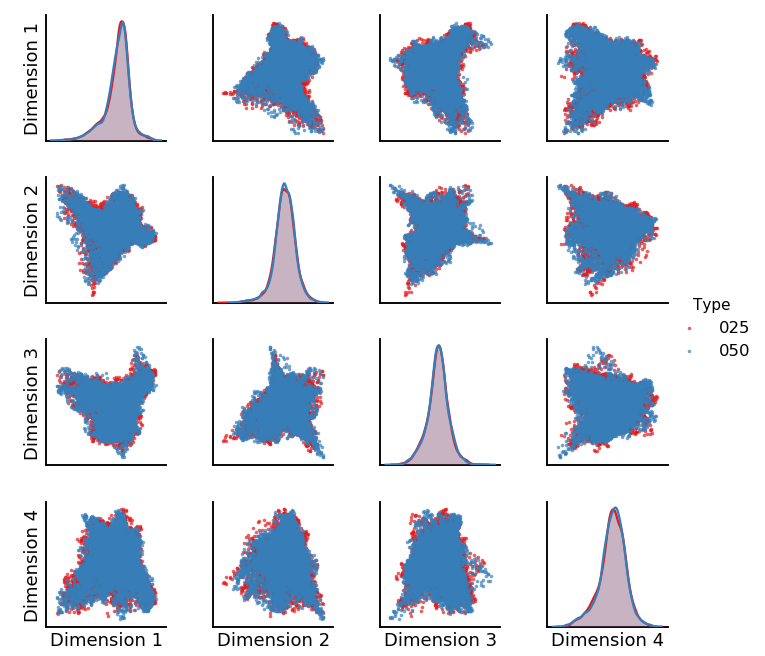

In [29]:
## Rupy Implementation
pairplot(np.vstack(projs2)[:,:4], labels=np.hstack((i*projs2[0].shape[0] for i in subjs)))

### Load MATLAB GCCA results

In [19]:
pathsM = []
subjsM = []
for f in os.listdir(basedir / 'data'):
    if f[-3:] == 'csv':
        pathsM.append(basedir / 'data' / f)
        subjsM.append('_'.join(f[:-4].split('_')[1:]))

In [55]:
projsM = []
subjsM2 = []
idx = [0,2]
for i in idx:
    projsM.append(pd.read_csv(pathsM[i], header=None).to_numpy())
    subjsM2.append(subjsM[i])

/home/rflperry/miniconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


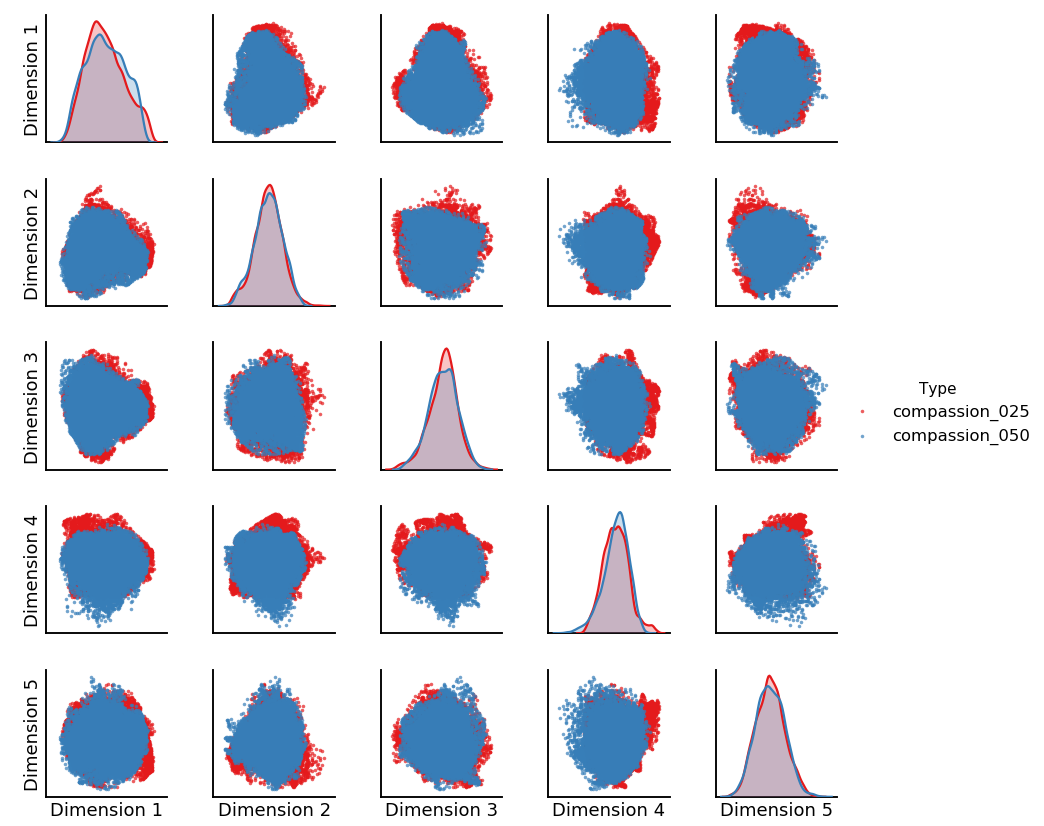

In [56]:
pairplot(np.vstack(projsM), labels=np.hstack(([i]*projsM[0].shape[0] for i in subjsM2)))

In [261]:
mpath = basedir / 'data' / 'matlab_A0.csv'
mdata = pd.read_csv(mpath, header=None).to_numpy()
print(linalg.norm(metadata[0]['A'] - mdata))

1.2868317394831101


In [268]:
mpath = basedir / 'data' / 'matlab_inv0.csv'
mdata = pd.read_csv(mpath, header=None).to_numpy()
print(linalg.norm(metadata[0]['inv'] - mdata, axis=0))

[1.21675e-08 4.44063e-03 5.21197e-03 4.30619e-03 4.80205e-03]


In [267]:
mpath = basedir / 'data' / 'matlab_V0.csv'
mdata = pd.read_csv(mpath, header=None).to_numpy()
print(linalg.norm(metadata[0]['V'][:,:5] - mdata[:,:5], axis=0))

[1.48339e-05 1.43984e-05 1.23271e-05 1.47303e-05 1.71329e-05]


In [269]:
linalg.solve(np.array([[0.5,0],[0,2]]), np.array([[1,-2],[2,1]]))

array([[ 2. , -4. ],
       [ 1. ,  0.5]])

In [270]:
linalg.solve(np.array([[0.5,0],[0,2]]), np.array([[1,-2],[-2,-1]]))

array([[ 2. , -4. ],
       [-1. , -0.5]])

In [275]:
metadata[0]['A'][:5,:]

array([[-0.00057,  0.00434, -0.01942,  0.01109,  0.01017],
       [ 0.0016 ,  0.00631, -0.04915,  0.01239, -0.00841],
       [ 0.00032, -0.00469, -0.04237,  0.02952, -0.00165],
       [-0.01758,  0.00602, -0.00022, -0.02125,  0.00213],
       [-0.02026,  0.02671, -0.01865, -0.02425,  0.0117 ]])